<a href="https://colab.research.google.com/github/99kenny/TSP/blob/main/TSP_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr style="border:2px solid gray"> </hr>

# Homework 1 - Traveling Salesman Problem

## Example Code

### Algorithm 3: Simulated Annealing

### Author: Wangduk Seo (CAU AI Lab)
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

---------------------------------------------------------------
## (Optional) For Colab

In [1]:
from google.colab import drive
import os, sys
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


---------------------------------------------------------------

In [2]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# SA
MAX_EVALUATION = 70
SUB_ITERATIONS = 50
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

# Plot Settings
PLOT_MODE = True # Draw Route
plt.ion()

# First City Index
FIRST_IDX = 0

In [3]:
file_path = '/content/gdrive/MyDrive/hw7/fi10639.txt'

# Step 1. Data Loading

In [4]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

# Step 2. Initialization

In [5]:
def initialize_greedy(cnt_cities, coord_list, first_idx):

    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)
    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = len(path) - 1
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

# Step 3. Searching a path

## Algorithm 2. Hill Climbing (2-opt search)

In [6]:
def two_opt_swap(path_map, path, iterations, coord_list):
    cnt_cities = len(path) - 1
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

In [7]:
def sa(path_map, path, coord_list):

    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()
    global TEMPERATURE

    for i in range(MAX_EVALUATION):
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

        if new_cost < best_cost:
            print("MAX EVAL -> ")
            print(i)
            best_path, best_cost = new_path, new_cost
          
    print("Cost : ")
    print(best_cost)

    return best_path, best_cost

In [8]:
def dnq(path_map, path, coord_list):
  size = 128
  cnt_cities = len(coord_list)
  sub_tours = []
  sub_tour_len = cnt_cities // size
  last_sub_tour_len = sub_tour_len + (cnt_cities % size)
  #size개의 sub tour
  for i in range(size):
    if i != size-1 :
      index = sub_tour_len
    else:
      index = last_sub_tour_len
    sub_tours.append(path.tolist()[i*sub_tour_len:i*sub_tour_len+index])
  new_path = []
  
  for j in range(size):
    sub_tours[j].append(sub_tours[j][0])
    best_path, best_cost = sa(path_map, np.array(sub_tours[j]), coord_list)
    new_path = new_path + (best_path.tolist()[0:-1])
   
  new_path.append(new_path[0])
  new_cost = path_cost(path_map, np.array(new_path)).sum()
  return new_path, new_cost

# Main

MAX EVAL -> 
16
MAX EVAL -> 
59
Cost : 
2975.6008855500886
MAX EVAL -> 
9
MAX EVAL -> 
52
MAX EVAL -> 
58
Cost : 
2615.4952092593467
MAX EVAL -> 
14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


MAX EVAL -> 
24
MAX EVAL -> 
43
Cost : 
3962.8003513000863
Cost : 
3320.4452754834447
MAX EVAL -> 
1
MAX EVAL -> 
4
MAX EVAL -> 
15
MAX EVAL -> 
20
MAX EVAL -> 
50
MAX EVAL -> 
62
Cost : 
3475.214210008927
MAX EVAL -> 
4
MAX EVAL -> 
32
MAX EVAL -> 
63
MAX EVAL -> 
69
Cost : 
3285.379869490293
MAX EVAL -> 
4
MAX EVAL -> 
39
Cost : 
2104.465590942364
MAX EVAL -> 
6
MAX EVAL -> 
12
MAX EVAL -> 
26
Cost : 
3984.061625195388
MAX EVAL -> 
3
MAX EVAL -> 
30
MAX EVAL -> 
64
Cost : 
3058.045053952895
MAX EVAL -> 
0
MAX EVAL -> 
15
Cost : 
4641.3475824292955
MAX EVAL -> 
21
Cost : 
4396.719826239691
MAX EVAL -> 
10
MAX EVAL -> 
45
Cost : 
4242.658556841983
MAX EVAL -> 
16
MAX EVAL -> 
22
MAX EVAL -> 
44
MAX EVAL -> 
55
Cost : 
1748.8407232791574
MAX EVAL -> 
0
MAX EVAL -> 
18
MAX EVAL -> 
22
MAX EVAL -> 
64
Cost : 
3983.29968398737
MAX EVAL -> 
12
MAX EVAL -> 
18
MAX EVAL -> 
44
Cost : 
4135.1386138450725
MAX EVAL -> 
2
MAX EVAL -> 
5
MAX EVAL -> 
10
MAX EVAL -> 
13
MAX EVAL -> 
20
MAX EVAL -> 

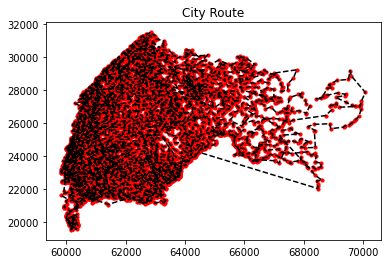

Execution Time: 65.31545543670654
Path: [0, 3, 35, 52, 66, 65, 64, 63, 34, 51, 75, 74, 116, 143, 117, 176, 211, 292, 291, 385, 496, 631, 694, 746, 747, 792, 843, 947, 993, 900, 946, 1034, 945, 791, 745, 629, 630, 562, 495, 494, 561, 628, 627, 560, 493, 383, 333, 289, 290, 384, 252, 210, 175, 142, 174, 141, 115, 209, 251, 250, 288, 332, 380, 381, 382, 433, 492, 626, 692, 693, 744, 790, 842, 841, 898, 897, 944, 943, 990, 1031, 1078, 1030, 989, 942, 941, 895, 838, 894, 893, 742, 624, 379, 285, 207, 172, 208, 248, 286, 287, 249, 331, 432, 491, 490, 559, 625, 743, 839, 896, 840, 991, 992, 1032, 1079, 1121, 1172, 1173, 1205, 1250, 1295, 1294, 1204, 1171, 1170, 1077, 1168, 1169, 1249, 1293, 1332, 1292, 1291, 1248, 1247, 1246, 1167, 1166, 1165, 1120, 1119, 1025, 986, 1026, 1027, 987, 1028, 1076, 1029, 988, 940, 892, 891, 939, 938, 985, 984, 937, 890, 889, 888, 936, 983, 982, 1024, 1070, 1114, 1159, 1160, 1161, 1162, 1115, 1071, 1116, 1163, 1202, 1243, 1290, 1242, 1201, 1241, 1289, 1288, 1368, 

In [9]:
# Initialization ###############
initialize = initialize_greedy
#initialize = initialize_random
################################

# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Step 2

cnt_cities = len(coord_list)
path_map, path = initialize(cnt_cities, coord_list, FIRST_IDX)

# Step 3
result_path, result_cost = dnq(path_map, path, coord_list)

if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[result_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[result_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(result_path))
print('Cost: ' + str(result_cost))
